In [1]:
import torch
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import transformer as transformer
import pickle

PRINT_EVERY = 100
N_EPOCHS = 100
LR = 1e-3
ES_PATIENCE = 10
N_SAMPLES = int(1e6)
SEQ_LENGTH = 10
N_REPEATS = 6
BATCH_SIZE = 2**8

/Users/hollymandel/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/hollymandel/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c1017RegisterOperatorsD1Ev)
  Referenced from: '/Users/hollymandel/miniconda3/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/hollymandel/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class binary_reverse(Dataset):
    def __init__(self, B = N_SAMPLES, N = SEQ_LENGTH, n_repeats = N_REPEATS):
        rand_data = np.eye(2)[np.random.choice(2, size=[B,int(N/2)])]
        rand_data = np.concatenate([rand_data,np.flip(rand_data,1)],1)
        rand_data = torch.from_numpy(rand_data.astype(np.float32))
        rand_data = torch.cat(
            [ rand_data[:,:,[0]].repeat(1,1,n_repeats),
            rand_data[:,:,[1]].repeat(1,1,n_repeats) ],
            dim = 2)
        self.data = rand_data[:,:-1,:]
        self.labels = rand_data[:,1:,[0,n_repeats]]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [3]:
class EarlyStopping:
    def __init__(self, patience=ES_PATIENCE, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.infty
        self.early_stop = False
        self.delta = delta

    def __call__(self, loss):
        if loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = min(loss, self.best_loss)
            self.counter = 0

In [4]:
def train_model(
    model, 
    data_loader, 
    optimizer_type = torch.optim.Adam, 
    # criterion = nn.MSELoss(), 
    criterion = nn.CrossEntropyLoss(),
    lr = LR,
    n_epochs = N_EPOCHS, 
    print_every = PRINT_EVERY,
    es_patience = ES_PATIENCE
):
    optimizer = optimizer_type(model.parameters(), lr)
    es = EarlyStopping(patience=es_patience, verbose=False)
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, dt in enumerate(data_loader, 0):
            inputs, labels = dt
            optimizer.zero_grad()
            outputs = model(inputs)
            # loss = criterion(outputs, labels)
            loss = criterion(outputs.view(-1,2), labels.argmax(-1).view(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % print_every == print_every-1:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, 1e3 * running_loss / print_every))
                es(running_loss)
                if es.early_stop:
                    return
                running_loss = 0.0

In [5]:
rand_data = binary_reverse(n_repeats = 1)
tf = transformer.Transformer(
    n_heads=1,
    N = SEQ_LENGTH-1,
    M = 12,
    embed_dim = 2,
    d_target = 2
)

data_loader = DataLoader(rand_data, batch_size=32, shuffle=True)
train_model(tf, data_loader, lr = 5e-3, )

/Users/hollymandel/Documents/llm_curriculum/1-transformers/transformer.py:32: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ks = torch.transpose(torch.range(0,M/2-1).repeat(N,1), 0,1)
/Users/hollymandel/Documents/llm_curriculum/1-transformers/transformer.py:22: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  return (torch.range(1,N).repeat(N,1) > torch.range(1,N).repeat(N,1).transpose(0,1)


[1,   100] loss: 700.893
[1,   200] loss: 504.163
[1,   300] loss: 360.859
[1,   400] loss: 328.545
[1,   500] loss: 322.402
[1,   600] loss: 319.744
[1,   700] loss: 318.757
[1,   800] loss: 317.776
[1,   900] loss: 315.101
[1,  1000] loss: 315.328
[1,  1100] loss: 315.186
[1,  1200] loss: 313.863
[1,  1300] loss: 315.422
[1,  1400] loss: 313.970
[1,  1500] loss: 312.933
[1,  1600] loss: 312.631
[1,  1700] loss: 312.154
[1,  1800] loss: 313.748
[1,  1900] loss: 312.525
[1,  2000] loss: 312.978
[1,  2100] loss: 313.241
[1,  2200] loss: 312.779
[1,  2300] loss: 312.380
[1,  2400] loss: 312.212
[1,  2500] loss: 312.433
[1,  2600] loss: 313.380
[1,  2700] loss: 312.331


post-errors: [0.500332, 0.5004109999999999, 0.5001789999999999, 0.5003500000000001, 0.0004709999999999992, 0.0004849999999999577, 0.0005089999999999817, 0.0004950000000000232, 0.0004089999999999927]


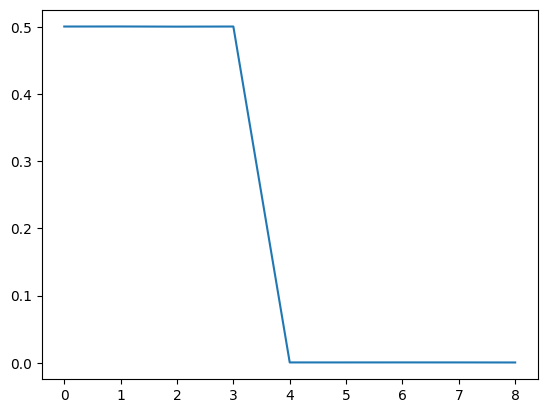

In [6]:
def error_rate(target, output):
    tgt_argmax = target.argmax(2).detach().numpy()
    out_argmax = output.argmax(2).detach().numpy()
    N = tgt_argmax.size
    return 1-np.sum(tgt_argmax * out_argmax + (1-tgt_argmax)*(1-out_argmax))/N

errs = []
for i in range(SEQ_LENGTH-1):
    errs.append(
        error_rate(rand_data[:][1][:,i:i+1,:], tf(rand_data[:][0])[:,i:i+1,:])
    )
print(f"post-errors: {errs}")
plt.plot(errs)